# Credit Default: Logistic Regression (scaled) vs Random Forest

**Optimized for ~30,000 rows.** This notebook:
- Cleans the provided dataset
- Uses a `StandardScaler + LogisticRegression` pipeline (more iterations so it converges)
- Trains a `RandomForestClassifier`
- Reports Accuracy, Precision, Recall, F1, ROC‑AUC
- Plots ROC curves and separate confusion matrices (matplotlib only)

> Set the `file_path` if your CSV is in a different folder.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix, classification_report)
import matplotlib.pyplot as plt

# 1) Load data
file_path = '/Users/ariunzul/Downloads/default-of-credit-card-clients-2.csv'  # change if needed
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


In [2]:
# 2) Clean & prepare features/target
# The first row contains the original header values; drop it.
df_clean = df.drop(index=0).copy()

# Drop ID-like columns
cols_to_drop = []
for col in ['Unnamed: 0', 'X1']:
    if col in df_clean.columns:
        cols_to_drop.append(col)
if cols_to_drop:
    df_clean = df_clean.drop(columns=cols_to_drop)

# Rename target column
if 'Y' in df_clean.columns:
    df_clean = df_clean.rename(columns={'Y': 'target'})

# Ensure numeric types
df_clean = df_clean.apply(pd.to_numeric, errors='coerce')
df_clean = df_clean.dropna()  # simple drop of any NaNs after coercion

X = df_clean.drop(columns=['target'])
y = df_clean['target'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.mean(), y_test.mean()

((21000, 22), (9000, 22), 0.2211904761904762, 0.2212222222222222)

In [3]:
# 3) Logistic Regression (scaled) — tuned for convergence on ~30k rows
log_reg_pipe = Pipeline([
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('logreg', LogisticRegression(
        solver='lbfgs',          # fast & stable for dense data
        penalty='l2',            # default
        C=1.0,
        max_iter=5000,           # plenty of iterations to avoid warnings
        n_jobs=None,             # lbfgs ignores n_jobs; keep None
        class_weight=None,       # set to 'balanced' if you need it
        tol=1e-4
    ))
])
log_reg_pipe.fit(X_train, y_train)
y_pred_log = log_reg_pipe.predict(X_test)
y_proba_log = log_reg_pipe.predict_proba(X_test)[:, 1]

log_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_log),
    'Precision': precision_score(y_test, y_pred_log, zero_division=0),
    'Recall': recall_score(y_test, y_pred_log, zero_division=0),
    'F1': f1_score(y_test, y_pred_log, zero_division=0),
    'ROC_AUC': roc_auc_score(y_test, y_proba_log)
}
log_metrics

{'Accuracy': 0.809,
 'Precision': 0.700589970501475,
 'Recall': 0.23857358111501759,
 'F1': 0.35593855376545525,
 'ROC_AUC': 0.7124628240407558}

In [4]:
# 4) Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

rf_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf, zero_division=0),
    'Recall': recall_score(y_test, y_pred_rf, zero_division=0),
    'F1': f1_score(y_test, y_pred_rf, zero_division=0),
    'ROC_AUC': roc_auc_score(y_test, y_proba_rf)
}
rf_metrics

{'Accuracy': 0.8158888888888889,
 'Precision': 0.6459790209790209,
 'Recall': 0.3711702661978905,
 'F1': 0.47145135566188195,
 'ROC_AUC': 0.7498492825361438}

In [5]:
# 5) Combined metrics table
metrics_df = pd.DataFrame([{'Model':'Logistic Regression', **log_metrics},
                           {'Model':'Random Forest', **rf_metrics}])
metrics_df

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression,0.809000,0.700590,0.238574,0.355939,0.712463
1,Random Forest,0.815889,0.645979,0.371170,0.471451,0.749849


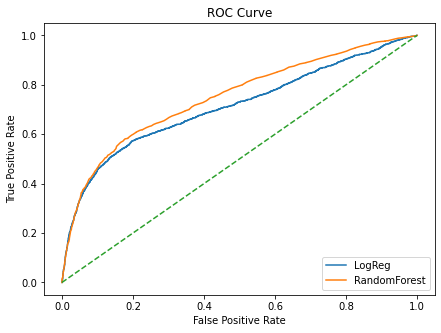

In [6]:
# 6) ROC curves (single chart)
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(7,5))
plt.plot(fpr_log, tpr_log, label='LogReg')
plt.plot(fpr_rf, tpr_rf, label='RandomForest')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

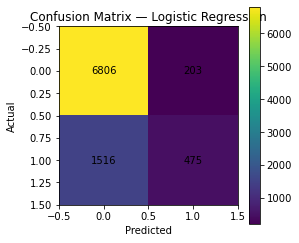

In [7]:
# 7) Confusion matrix — Logistic Regression (separate chart)
cm_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(4,4))
plt.imshow(cm_log, interpolation='nearest')
plt.title('Confusion Matrix — Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
for (i, j), val in np.ndenumerate(cm_log):
    plt.text(j, i, int(val), ha='center', va='center')
plt.colorbar()
plt.show()

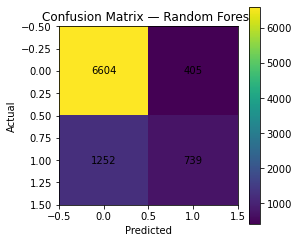

In [8]:
# 8) Confusion matrix — Random Forest (separate chart)
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(4,4))
plt.imshow(cm_rf, interpolation='nearest')
plt.title('Confusion Matrix — Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
for (i, j), val in np.ndenumerate(cm_rf):
    plt.text(j, i, int(val), ha='center', va='center')
plt.colorbar()
plt.show()

In [9]:
# 9) Feature effects / importances
importances = pd.Series(rf_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.head(20)

X6     0.101748
X5     0.075769
X12    0.064201
X13    0.056301
X17    0.054248
X14    0.054080
X18    0.053914
X16    0.053605
X15    0.052535
X19    0.051239
X20    0.050033
X23    0.049667
X7     0.049426
X22    0.046716
X21    0.045431
X8     0.026527
X9     0.023529
X10    0.022559
X3     0.021442
X11    0.020107
dtype: float64

In [10]:
# 10) Logistic coefficients on standardized scale
logreg = log_reg_pipe.named_steps['logreg']
coef = pd.Series(logreg.coef_.ravel(), index=X.columns).sort_values(key=abs, ascending=False)
coef

X6     0.657902
X12   -0.343398
X19   -0.275294
X18   -0.163523
X14    0.119374
X7     0.117459
X8     0.092731
X3    -0.074115
X4    -0.070476
X9     0.061782
X2    -0.054850
X21   -0.054679
X23   -0.050931
X5     0.048220
X17    0.040441
X22   -0.037374
X15    0.036144
X20   -0.034904
X11    0.032232
X10    0.020406
X16   -0.019304
X13    0.009842
dtype: float64

### Notes
- If you still see convergence warnings for Logistic Regression, you can:
  1. Increase `max_iter` to `10000`.
  2. Switch to `solver='saga'` (works well for large datasets and L1/L2 penalties).
  3. Use `class_weight='balanced'` if your target is imbalanced.
- Random Forest hyperparameters above are reasonable defaults for ~30k rows; you can tune `n_estimators` and `max_depth` for speed/accuracy trade-offs.